In [1]:
import pandas as pd
import re
import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
from typing import List
from nltk.tokenize import word_tokenize

In [2]:
def filter_stop_words(text: List[str])->List[str]:
    stop_words = set(stopwords.words("english"))
    return [word for word in text if word not in stop_words]

dialogues = pd.read_csv('../code/emo_context_train.txt', sep="\t")

#dialogues = dialogues[dialogues["label"]!="others"]
labels = dialogues.label
cols = ["turn1", "turn2", "turn3"]
dialogues["combined"] = dialogues[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
#dialogues["combined"] = dialogues["combined"].apply(str.lower).apply(word_tokenize).apply(filter_stop_words).apply(lambda x: " ".join(x))
dialogues["combined"] = dialogues["combined"].apply(str.lower).apply(word_tokenize).apply(lambda x: " ".join(x))
dialogues["seq_len"] = dialogues["combined"].apply(len)
print(dialogues.columns)

max_len = dialogues["seq_len"].max()
input_text = dialogues.combined.values

Index(['id', 'turn1', 'turn2', 'turn3', 'label', 'combined', 'seq_len'], dtype='object')


In [3]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import math 
import sklearn
from sklearn import metrics

2023-05-07 14:47:39.030712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Split data into train and test and vectorise

In [9]:
X = input_text
label_map = {'happy':0,'sad':1,'angry':2, 'others':3}
#label_map = {'happy':0,'sad':1,'angry':2}
y = dialogues['label'].map(label_map)

y = np.asarray(y).astype('float32')
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

0        3
1        2
2        3
3        2
4        3
        ..
30155    3
30156    1
30157    3
30158    3
30159    3
Name: label, Length: 30160, dtype: int64
<class 'numpy.ndarray'>
30160


In [10]:
embed_dim = 128
lstm_out = 64

max_features = 2000
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32,activation='softmax'))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 152, 128)          256000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 152, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 307,620
Trainable params: 307,620
Non-trainable params: 0
________________________________________________

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
batch_size = 32
model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=2)

Epoch 1/5
754/754 - 55s - loss: 1.1330 - accuracy: 0.5634 - 55s/epoch - 74ms/step
Epoch 2/5
754/754 - 58s - loss: 0.9257 - accuracy: 0.6690 - 58s/epoch - 77ms/step
Epoch 3/5
754/754 - 58s - loss: 0.7194 - accuracy: 0.7359 - 58s/epoch - 77ms/step
Epoch 4/5
754/754 - 55s - loss: 0.6281 - accuracy: 0.7743 - 55s/epoch - 73ms/step
Epoch 5/5
754/754 - 56s - loss: 0.4792 - accuracy: 0.8671 - 56s/epoch - 74ms/step


In [12]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

189/189 - 3s - loss: 0.5040 - accuracy: 0.8473 - 3s/epoch - 16ms/step
score: 0.50
acc: 0.85


In [13]:
from sklearn.metrics import classification_report
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)

print("f1 score", sklearn.metrics.f1_score(y_test, y_prediction, average='macro'))
print(y_prediction)
print(classification_report(y_test, y_prediction,))

189/189 [==============================] - 3s 15ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
f1 score 0.8318026951580568
[0 3 1 ... 0 3 3]
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       839
         1.0       0.88      0.75      0.81      1067
         2.0       0.85      0.84      0.84      1075
         3.0       0.85      0.90      0.87      3051

    accuracy                           0.85      6032
   macro avg       0.84      0.82      0.83      6032
weighted avg       0.85      0.85      0.85      6032



In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


labels = ['happy','sad','angry','others']
num_labels = [0,1,2,3]
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_prediction, labels=num_labels)
display(confusion_matrix)

array([[ 677,    5,    8,  149],
       [  15,  800,   61,  191],
       [  15,   22,  901,  137],
       [ 144,   79,   95, 2733]])

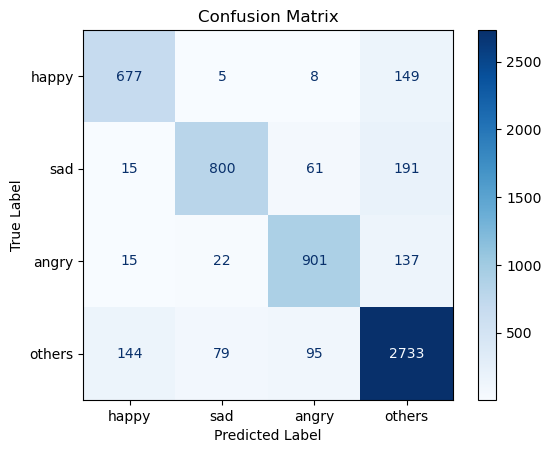

In [15]:
color = 'black'

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, y_prediction,))